## Part 2a: generate disv properties

In [1]:
import sys, json, os ## Org
import rasterio, flopy ## Org
import numpy as np ## Org
import matplotlib.pyplot as plt ## Org
import geopandas as gpd ## Org
from mf6Voronoi.meshProperties import meshShape ## Org
from shapely.geometry import MultiLineString ## Org
from mf6Voronoi.tools.graphs2d import generateRasterFromArray ## <==== updated
from mf6Voronoi.tools.cellWork import getLayCellElevTupleFromRaster, getLayCellElevTupleFromElev  ## <==== updated

c:\Users\saulm\anaconda3\Lib\site-packages\pyvista\examples\downloads.py:93: DeprecationWarning: support for supplying keyword arguments to pathlib.PurePath is deprecated and scheduled for removal in Python 3.14
  Path(USER_DATA_PATH, exist_ok=True).mkdir()
c:\Users\saulm\anaconda3\Lib\site-packages\pyvista\examples\downloads.py:98: UserWarning: Unable to access C:\Users\saulm\AppData\Local\pyvista_3\pyvista_3\Cache. Manually specify the PyVistaexamples cache with the PYVISTA_USERDATA_PATH environment variable.
  warnings.warn(


In [2]:
# open the json file
with open('../json/disvDict.json') as file: ## <==== updated
    gridProps = json.load(file) ## Org

In [3]:
cell2d = gridProps['cell2d']           #cellid, cell centroid xy, vertex number and vertex id list
vertices = gridProps['vertices']       #vertex id and xy coordinates
ncpl = gridProps['ncpl']               #number of cells per layer
nvert = gridProps['nvert']             #number of verts
centroids=gridProps['centroids']       #cell centroids xy 

## Part 2b: Model construction and simulation

In [4]:
#Extract dem values for each centroid of the voronois
#first 4 layers
finalSurf = rasterio.open('../rst/demWithDamAndTailings.tif')  ## <==== updated
finalSurfElev = [x for x in finalSurf.sample(centroids)] ## <==== updated

#second 4 layers
botTailings = rasterio.open('../rst/demWithDam.tif') ## <==== updated
botTailingsElev = [x for x in botTailings.sample(centroids)] ## <==== updated

orgSurf = rasterio.open('../rst/tsfDem10m.tif') ## <==== updated
orgSurfElev = [x for x in orgSurf.sample(centroids)] ## <==== updated

In [5]:
nlay = 19   ## Org

fsurf=np.array([elev[0] for i,elev in enumerate(finalSurfElev)]) ## <==== updated
#4 layers of 2m for tailings
btail=np.array([elev[0] - 8 for i,elev in enumerate(botTailingsElev)]) ## <==== updated
#bottom of 1m geomembrane
geob=np.array([elev[0] - 9 for i,elev in enumerate(botTailingsElev)])
#4 layers of 2m for dam 
osurf=np.array([elev[0] - 17 for i,elev in enumerate(orgSurfElev)]) ## <==== updated

zbot=np.zeros((nlay,ncpl)) ## Org
mtop = fsurf 
AcuifInf_Bottom = 170 ## <==== updated

zbot[0,] = btail + 0.75*(fsurf - btail) ## <==== updated
zbot[1,] = btail + 0.5*(fsurf - btail) ## <==== updated
zbot[2,] = btail + 0.25*(fsurf - btail) ## <==== updated
zbot[3,] = btail ## <==== updated
zbot[4,] = geob ## <==== updated
zbot[5,] = osurf + 0.75*(geob - osurf) ## <==== updated
zbot[6,] = osurf + 0.5*(geob - osurf) ## <==== updated
zbot[7,] = osurf + 0.25*(geob - osurf) ## <==== updated
zbot[8,] = osurf ## <==== updated
zbot[9,] = AcuifInf_Bottom + (0.95 * (osurf - AcuifInf_Bottom)) ## <==== updated
zbot[10,] = AcuifInf_Bottom + (0.90 * (osurf - AcuifInf_Bottom)) ## <==== updated
zbot[11,] = AcuifInf_Bottom + (0.85 * (osurf - AcuifInf_Bottom)) ## <==== updated 85%
zbot[12,] = AcuifInf_Bottom + (0.78 * (osurf - AcuifInf_Bottom)) ## <==== updated 
zbot[13,] = AcuifInf_Bottom + (0.71 * (osurf - AcuifInf_Bottom)) ## <==== updated 
zbot[14,] = AcuifInf_Bottom + (0.64 * (osurf - AcuifInf_Bottom)) ## <==== updated 
zbot[15,] = AcuifInf_Bottom + (0.57 * (osurf - AcuifInf_Bottom)) ## <==== updated 
zbot[16,] = AcuifInf_Bottom + (0.50 * (osurf - AcuifInf_Bottom)) ## <==== updated 50%
zbot[17,] = AcuifInf_Bottom + (0.25 * (osurf - AcuifInf_Bottom)) ## <==== updated
zbot[18,] = AcuifInf_Bottom ## <==== updated

In [6]:
np.array(finalSurfElev).min()

517

### Create simulation and model

In [7]:
# create simulation
simName = 'mf6Sim' ## Org
modelName = 'mf6Model' ## Org
modelWs = os.path.abspath('../modelFiles') ## <=== updated
sim = flopy.mf6.MFSimulation(sim_name=modelName, version='mf6', ## Org
                             exe_name='../bin/mf6.exe', ## <===== updated
                             continue_=True, ## <===== updated
                             sim_ws=modelWs) ## Org

In [8]:
# create tdis package
tdis_rc = [(80*86400*365, 10, 1.0)] ## <===== updated
tdis = flopy.mf6.ModflowTdis(sim, pname='tdis', time_units='SECONDS', ## Org
                             perioddata=tdis_rc) ## Org

In [9]:
# create gwf model
gwf = flopy.mf6.ModflowGwf(sim, ## Org
                           modelname=modelName, ## Org
                           save_flows=True, ## Org
                           newtonoptions="NEWTON UNDER_RELAXATION") ## Org

In [10]:
# # create iterative model solution and register the gwf model with it
# ims = flopy.mf6.ModflowIms(sim, ## Org
#                            complexity='COMPLEX', ## Org
#                            outer_maximum=150, ## Org
#                            inner_maximum=50, ## Org
#                            outer_dvclose=0.1, ## Org
#                            inner_dvclose=0.0001, ## Org
#                            backtracking_number=20, ## Org
#                            linear_acceleration='BICGSTAB') ## Org
# sim.register_ims_package(ims,[modelName]) ## Org

In [11]:
# create iterative model solution and register the gwf model with it
ims = flopy.mf6.ModflowIms(sim, ## Org
                           complexity='COMPLEX', ## Org
                           outer_maximum=50, ## Org
                           inner_maximum=30, ## Org
                           linear_acceleration='BICGSTAB') ## Org
sim.register_ims_package(ims,[modelName]) ## Org

In [12]:
# disv
disv = flopy.mf6.ModflowGwfdisv(gwf, nlay=nlay, ncpl=ncpl, ## Org
                                top=mtop, botm=zbot, ## Org
                                nvert=nvert, vertices=vertices, ## Org
                                cell2d=cell2d) ## Org

In [13]:
# initial conditions
waterTableRst = rasterio.open('../rst/regWaterTable.tif')  ## <==== updated
waterTable = [x for x in waterTableRst.sample(centroids)] ## <==== updated
#ic = flopy.mf6.ModflowGwfic(gwf, strt=np.stack([mtop for i in range(nlay)])) ## Org
ic = flopy.mf6.ModflowGwfic(gwf, strt=np.stack([waterTable for i in range(nlay)])) ## <==== updated

[<Axes: title={'center': 'strt layer 1'}>]

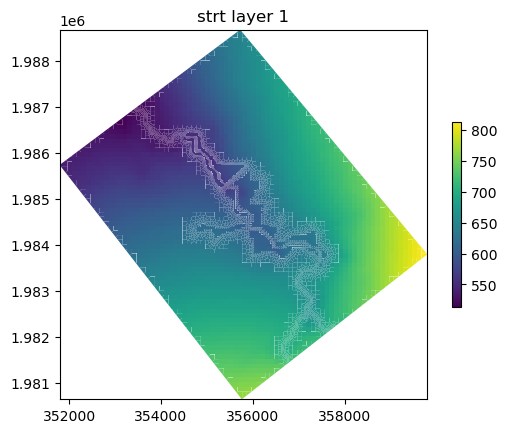

In [14]:
ic.plot(mflay=0) ## <==== updated

In [15]:
ncplArray = np.ones(ncpl)
Kx =[4E-4*ncplArray for i in range(9)] + [5e-6*ncplArray for i in range(3)] + \
    [8e-7*ncplArray for i in range(5)] + [5e-8*ncplArray for i in range(2)] ## <==== updated
kxArray = np.stack(Kx)
icelltype = [1 for i in range(14)] + [0 for i in range(5)] ## <=== updated

# Define intersection object
interIx = flopy.utils.gridintersect.GridIntersect(gwf.modelgrid) ## <==== inserted

damGeom = gpd.read_file('../shp/tsf/damEnvelope_v2.shp').iloc[0].geometry
damCells = interIx.intersect(damGeom).cellids
kxArray[0:9,damCells.tolist()] = 2e-5


tailingsGeom = gpd.read_file('../shp/tsf/tailingsEnvelope_v2.shp').iloc[0].geometry
tailingsCells = interIx.intersect(tailingsGeom).cellids
kxArray[:4,tailingsCells.tolist()] = 5e-6

#falta la geomembrana


# node property flow
npf = flopy.mf6.ModflowGwfnpf(gwf, ## Org
                              save_specific_discharge=True, ## Org
                              save_flows=True, ## <==== inserted
                              save_saturation=True, ## <==== inserted
                              icelltype=icelltype, ## Org
                              k=kxArray, ## <==== inserted
                              k33=kxArray) ## <==== inserted

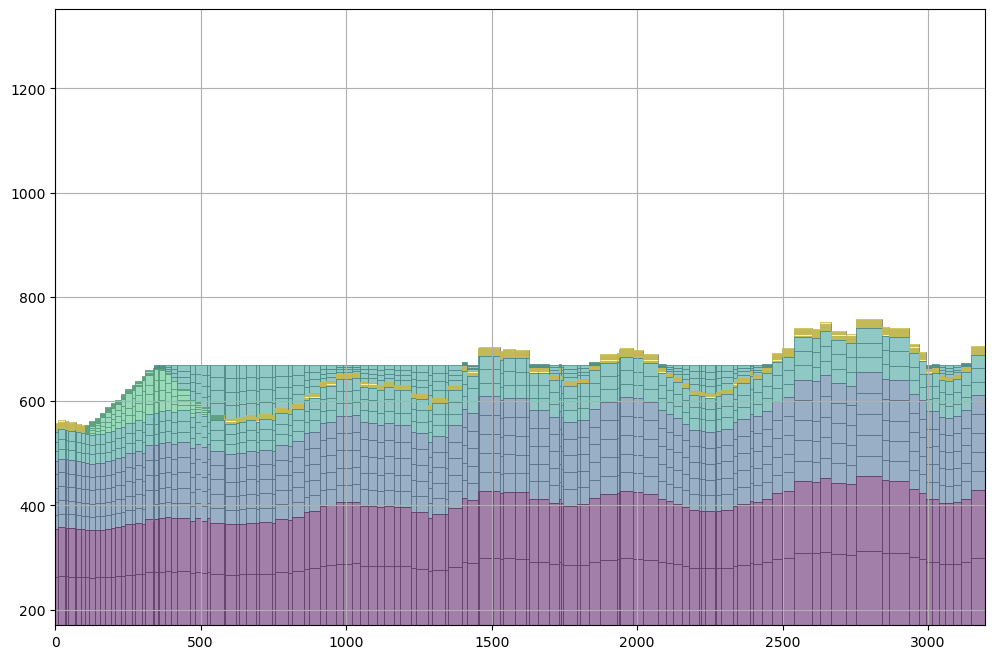

In [16]:
## <==== inserted
crossSection = gpd.read_file('../shp/tsf/crossSection.shp') ## <==== inserted
sectionLine =list(crossSection.iloc[0].geometry.coords) ## <==== inserted

fig, ax = plt.subplots(figsize=(12,8)) ## <==== inserted
modelxsect = flopy.plot.PlotCrossSection(model=gwf, line={'Line': sectionLine}) ## <==== inserted
linecollection = modelxsect.plot_grid(lw=0.5) ## <==== inserted
modelxsect.plot_array(np.log(npf.k.array), alpha=0.5) ## <====== inserted
ax.grid() ## <==== inserted

In [17]:
# define storage and transient stress periods
sto = flopy.mf6.ModflowGwfsto(gwf, ## Org
                              iconvert=1, ## Org
                              steady_state={ ## Org
                                0:True, ## Org
                              } ## Org
                              ) ## Org

#### Working with rechage, evapotranspiration

In [18]:
rchr = 0.15/365/86400 ## Org
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=rchr) ## Org
evtr = 1.2/365/86400 ## Org
evt = flopy.mf6.ModflowGwfevta(gwf,ievt=1,surface=mtop,rate=evtr,depth=1.0) ## Org

### Definition of the intersect object
For the manipulation of spatial data to determine hydraulic parameters or boundary conditions

In [19]:
# Define intersection object
interIx = flopy.utils.gridintersect.GridIntersect(gwf.modelgrid) ## Org

In [20]:
#open the river shapefile
rivers =gpd.read_file('../hatariUtils/river_network.shp') ## <==== river network
list_rivers=[] ## Org
for i in range(rivers.shape[0]): ## Org
    list_rivers.append(rivers['geometry'].loc[i]) ## Org
    
riverMls = MultiLineString(lines=list_rivers) ## Org

#intersec rivers with our grid
riverCells=interIx.intersect(riverMls).cellids ## Org
riverCells[:10] ## Org

array([279, 289, 316, 322, 349, 350, 358, 381, 384, 428], dtype=object)

In [21]:
#river package
riverSpd = {} ## Org
riverSpd[0] = [] ## Org
for cell in riverCells: ## Org
    riverSpd[0].append([(0,cell),mtop[cell],0.001]) ## Org
    # riverSpd[0].append([(1,cell),mtop[cell],0.01]) ## <==== updated
    # riverSpd[0].append([(2,cell),mtop[cell],0.01]) ## <==== updated
riv = flopy.mf6.ModflowGwfdrn(gwf, stress_period_data=riverSpd) ## Org

[<Axes: title={'center': ' drn_0 location stress period 1 layer 1'}>]

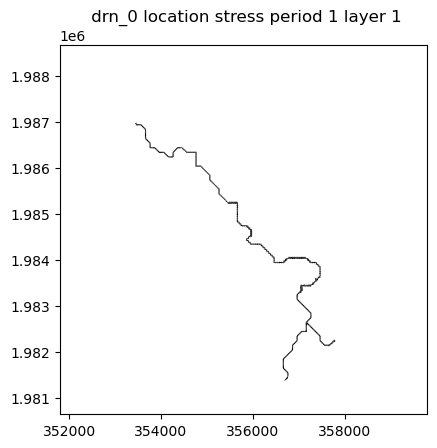

In [22]:
#river plot
riv.plot(mflay=0) ## Org

In [23]:
#river package # <===== Inserted
layCellTupleList, cellElevList = getLayCellElevTupleFromRaster(gwf,
                                                               interIx,
                                                               '../rst/regWaterTable.tif',
                                                               '../shp/tsf/regionalFlow.shp') ## # <===== Inserted
regionalSpd = {} ## # <===== Inserted
regionalSpd[0] = [] ## # <===== Inserted
for index, layCellTuple in enumerate(layCellTupleList): ## Org
    regionalSpd[0].append([layCellTuple,cellElevList[index],0.01]) # <===== Inserted

The cell 322 has a elevation of 519.06 outside the model vertical domain
The cell 323 has a elevation of 518.79 outside the model vertical domain
The cell 326 has a elevation of 519.16 outside the model vertical domain
The cell 5531 has a elevation of 715.13 outside the model vertical domain
The cell 5538 has a elevation of 717.05 outside the model vertical domain
The cell 5539 has a elevation of 715.39 outside the model vertical domain
The cell 5541 has a elevation of 718.16 outside the model vertical domain


In [24]:
ghb = flopy.mf6.ModflowGwfghb(gwf, stress_period_data=regionalSpd) ## <==== modified

[<Axes: title={'center': ' ghb_0 location stress period 1 layer 13'}>]

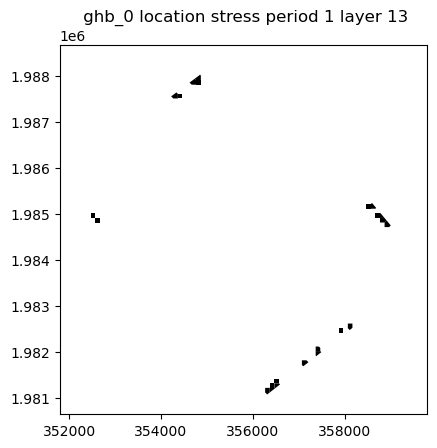

In [25]:
#regional flow plot
ghb.plot(mflay=12, kper=0) ## <===== modified

### Set the Output Control and run simulation

In [26]:
#oc
head_filerecord = f"{gwf.name}.hds" ## Org
budget_filerecord = f"{gwf.name}.cbc" ## Org
oc = flopy.mf6.ModflowGwfoc(gwf, ## Org
                            head_filerecord=head_filerecord, ## Org
                            budget_filerecord = budget_filerecord, ## Org
                            saverecord=[("HEAD", "ALL"),("BUDGET","ALL")]) ## <==== updated

In [27]:
# Run the simulation
sim.write_simulation() ## Org
success, buff = sim.run_simulation() ## Org

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model mf6Model...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package rcha_0...
    writing package evta_0...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 533 based on size of stress_period_data
    writing package ghb_0...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 289 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ..\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.0 12/20/2024

   MODFLOW 6 compiled Dec 31 2024 17:10:16 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applicatio

### Model output visualization

In [28]:
headObj = gwf.output.head() ## Org
headObj.get_kstpkper() ## Org

[(0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 0),
 (6, 0),
 (7, 0),
 (8, 0),
 (9, 0)]

In [29]:
heads = headObj.get_data() ## Org
heads[2,0,:5] ## Org

array([544.32317294, 548.3647016 , 541.34409644, 539.43150513,
       546.02750723])

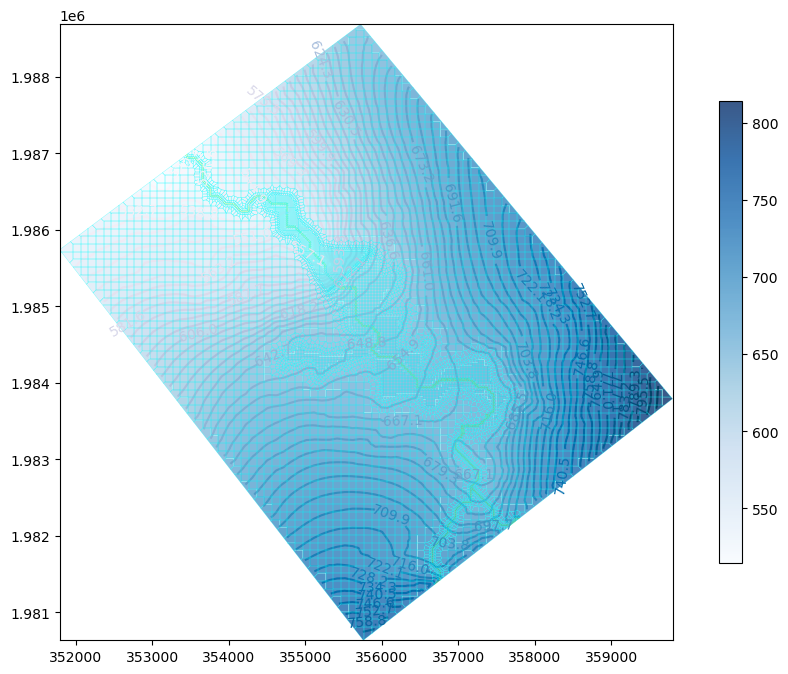

In [30]:
# Plot the heads for a defined layer and boundary conditions
fig = plt.figure(figsize=(12,8)) ## Org
ax = fig.add_subplot(1, 1, 1, aspect='equal') ## Org
modelmap = flopy.plot.PlotMapView(model=gwf) ## Org

####
levels = np.linspace(heads[heads>-1e+30].min(),heads[heads>-1e+30].max(),num=50) ## Org
contour = modelmap.contour_array(heads[3],ax=ax,levels=levels,cmap='PuBu') ## Org
ax.clabel(contour) ## Org


quadmesh = modelmap.plot_bc('DRN') ## Org
cellhead = modelmap.plot_array(heads[3],ax=ax, cmap='Blues', alpha=0.8) ## Org

linecollection = modelmap.plot_grid(linewidth=0.3, alpha=0.5, color='cyan', ax=ax) ## Org

plt.colorbar(cellhead, shrink=0.75) ## Org

plt.show() ## Org

In [31]:
waterTable = flopy.utils.postprocessing.get_water_table(heads)
generateRasterFromArray(gwf, 
                        waterTable,
                        meshLayer='../output/tailingsStorage.shp', 
                        rasterRes=10, 
                        epsg=32614, 
                        outputPath='../output/waterTable.tif')

Raster X Dim: 8005.97, Raster Y Dim: 8046.35
Number of cols:  801, Number of rows: 805
